In [6]:
top_20_median = [(34.64672, 673.0), (33.2039185, 644.0), (32.70846, 51.0), (32.655786, 212.0), (31.7744935, 494.0), (31.485426, 656.0), (31.485426, 687.0), (31.485426, 688.0), (31.220772, 751.0), (30.723377, 105.0), (30.671291, 146.0), (30.671291, 579.0), (30.599202, 994.0), (30.016037, 175.0), (29.938318, 639.0), (29.669577, 140.0), (29.669577, 371.0), (29.669577, 374.0), (29.4584715, 469.0), (27.905577, 563.0)]
top_20_mean = [(35.109816620000004, 673.0), (34.13331814, 644.0), (33.30713318, 51.0), (33.22862808, 494.0), (32.07007306, 212.0), (31.931849120000003, 656.0), (31.931849120000003, 687.0), (31.931849120000003, 688.0), (31.76913274, 994.0), (31.75993412, 175.0), (31.5500617, 105.0), (31.42320878, 236.0), (31.35900574, 751.0), (31.10624868, 140.0), (31.10624868, 371.0), (31.10624868, 374.0), (30.84826642, 146.0), (30.84826642, 579.0), (30.46877688, 639.0), (30.45435548, 376.0)]

In [7]:
import pandas as pd
claim_df = pd.read_csv("./claimretrieval/IndexClaimCategory.csv")
claim_df.dropna(axis='columns', how='all', inplace=True)  # Drop any columns that are all N/A
claim_df.dropna(axis='index', how='any', inplace=True) 

'Less common symptom of Covid is chills/dizziness'

In [24]:
top_20_median.extend( top_20_mean )
top_20_claims = list(set([claim for (score, claim) in top_20_median]))
claim_text = claim_df.iloc[top_20_claims]['Claim']
claim_text

648     A post claims that there are no cases of the n...
142     A photo of a man and woman embracing has been ...
660     Image claims to show dozens of coffins of Ital...
148     A video of food packets deposited on a street ...
677     Tanzanian club spokesman Haji S. Manara was in...
691     Javier Ortega Smith, from VOX, has said that h...
692     Goats in Ajmer, Rajasthan were found to be COV...
177     A video has been viewed thousands of times in ...
51      remdesivir, hydroxychloroquine, lopinavir/rito...
566     A viral WhatsApp voice note in Nigeria claims ...
582     IPhoto shows people falling dead on Italian st...
214     Boil weed and ginger for COVID-19 victims, and...
471     A purported news report claims that Philippine...
1002    Chinese President Xi Jinping visited Muslims t...
107     The WHO has issued a protocol for lockdown ext...
238       Lemon and bicarbonate can cure coronavirus.\t\t
496     The names of coronavirus victims have been pub...
759     “Peopl

In [27]:
claim_text.iloc[2]

'Image claims to show dozens of coffins of Italians who have died from COVID-19.\t\t'

# Query Elastic

In [294]:
from elasticsearch import Elasticsearch
import elasticsearch
import elasticsearch.helpers

import json
elastic_client = Elasticsearch(hosts=["http://143.167.8.152:9300"], http_auth=('students', 'foxtrot'))

def search_for_terms(amount, claim_dict, duplicate_ids=[]):
    """
    Search using a term_frequency dictionary
    :param amount: integer number of tweets to return
    :param claim_dict: dictionary of {term: frequency}s
    :return: array of tweet IDs
    """

    must_array = [{"match": {"is_a_retweet": "false"}}, {"match": {"is_a_quote": "false"}}]
    should_array = [{"match": {"tweet_text": "*" + term + "*"}} for term, frequency in claim_dict.items()]
    query_body = {
        "size": amount,
        "query": {
            "bool": {
                "must": must_array,
                "must_not": [
                    {"match": {"hashtags": "obamagate"}},
                    {"exists": {"field": "in_reply_to_user_id"}},
                    {"exists": {"field": "in_reply_to_status_id"}},
                    {"exists": {"field": "in_reply_to_screen_name"}},
                    {"match": {"message": "*media_url*"}}
                ],
                "should": should_array
            }
        },
        "track_total_hits": True
    }

    result = elasticsearch.helpers.scan(client=elastic_client, index="covid19_misinfo_index", query=query_body, 
                                        scroll="1m", 
                                        request_timeout=999999, 
                                        _source="tweet_id", )  #

    return [item["_source"]["tweet_id"] for item in result]

def text_from_id(ids):
    should_array = []

    for x in ids:
        should_array.append({"match": {"tweet_id": x}})
    query_body = {
        "query": {
            "bool": {
                 "should": should_array
            }
        },
        "collapse": {
            "field": "tweet_id.keyword"
        }
    }

    result = elastic_client.search(index="covid19_misinfo_index", body=query_body, request_timeout=999999, size=len(ids))

    all_hits = result['hits']['hits']
    res = []
    for num, doc in enumerate(all_hits):
        res.append([ doc["_source"]["tweet_text"], doc["_source"]["tweet_created_at"] ])
    
    
    return res

In [28]:
import pandas as pd
from querytweets import queries
from claimretrieval import tweet_query

claim_query = tweet_query.construct_query(claim_text[51]) # Term frequency dict
print(claim_query)

{'remdesivir': 1, 'hydroxychloroquine': 1, 'lopinavir/ritonavir': 1, 'interferon': 1, 'regimen': 1, 'efficient': 1, 'treatment': 1}


In [295]:
# Query elastic for tweets based on claims
# ToDo: Multiple claims
ids_and_scores = []
'''
duplicate_ids = []
for i in range( 0, 10 ):   
    new_terms = search_for_terms(1000, claim_query, duplicate_ids)
    ids_and_scores.extend(new_terms)
    duplicate_ids = list(set([twid for twid, score in new_terms]))
'''
new_terms = search_for_terms(10000, claim_query)
scores = [score for twid, score in ids_and_scores]
tweet_ids = set([twid for twid, score in ids_and_scores])

KeyboardInterrupt: 

In [ ]:
len(tweet_ids)

In [209]:
'''
tweet_texts = text_from_id(tweet_ids)
all_tweets = [[tweet_id, tweet_text, tweet_date] for tweet_id, (tweet_text, tweet_date) in zip(tweet_ids, tweet_texts)]
df = pd.DataFrame(data=all_tweets, columns=['id', 'text', 'full_date'])
'''

RequestError: RequestError(400, 'search_phase_execution_exception', 'failed to create query: maxClauseCount is set to 1024')

In [ ]:
len(df)

In [213]:
df = pd.DataFrame(data=[], columns=['id', 'text', 'full_date'])
for end_r in range( 1000, len(tweet_ids)+1, 1000):
    tweet_texts = text_from_id(tweet_ids[(end_r-1000):end_r])
    new = pd.DataFrame(data=[ [tweet_id,tweet_text, tweet_date] 
                             for tweet_id, (tweet_text, tweet_date) in zip(tweet_ids[(end_r-1000):end_r], tweet_texts)], 
                       columns=['id', 'text', 'full_date'])
    new['full_date'] = pd.to_datetime(new['full_date'], format='%Y-%m-%d %H:%M:%S')
    new['date'] = [d.date() for d in new['full_date']]
    new['time'] = [d.time() for d in new['full_date']]
    df = df.append(new)
df.reset_index(inplace=True)
df.head()

,index,date,full_date,id,text,time
0,0,2020-11-09,2020-11-09 23:45:06,1318572096277139462,A comparison of four re-purposed antiviral dru...,23:45:06
1,1,2020-11-04,2020-11-04 18:47:57,1317360631452897280,Coronavirus treatment: Do #Remdesivir and #Hyd...,18:47:57
2,2,2020-11-02,2020-11-02 17:56:28,1317175283234070533,#Remdesivir Study Accidentally Proves #Hydroxy...,17:56:28
3,3,2020-11-01,2020-11-01 11:35:03,1317056251881283584,Early #treatment with #hydroxychloroquine: a c...,11:35:03
4,4,2020-11-01,2020-11-01 17:32:04,1317236840768954368,Early intervention and treatment of high-risk ...,17:32:04


In [216]:
df.to_csv('5000 hydro tweets.csv')

C:\Users\Ruxandra\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


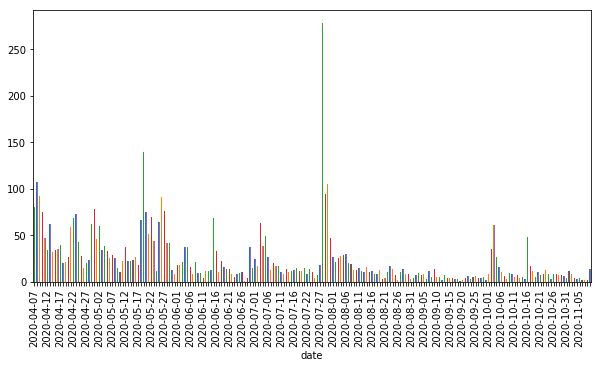

In [214]:
from matplotlib import pyplot as plt
import numpy as np


week_groups = df.groupby('date').count()
week_groups.plot(kind='bar',figsize=(10,5),legend=None)
ax = plt.axes()
every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

In [215]:
week_groups.full_date.nlargest(10)

date
2020-07-28    278
2020-05-19    140
2020-04-08    107
2020-07-30    105
2020-07-29     94
2020-04-09     92
2020-05-26     91
2020-04-07     80
2020-04-30     78
2020-05-27     76
Name: full_date, dtype: int64

27th of May - https://www.theguardian.com/world/2020/may/27/global-report-european-countries-act-against-use-hydroxychloroquine-infections-up-south-korea

5th of July - WHO published report discontinuing the use of hydroxichloroquine as a COVID treatment

28th of July - https://edition.cnn.com/world/live-news/coronavirus-pandemic-07-28-20-intl/h_65a0166f6c2b36d20119c394eb34ad6e

16th of October - Remdesivir is also useless https://www.theguardian.com/world/2020/oct/16/remdesivir-has-very-little-effect-on-covid-19-mortality-who-finds-trial-drug-coronavirus

10th of October - possibly linked to Trump discussing his treatment